### Optimizing parameters for cellulose growth

Data:
- Cellulose concentration
- Biomass concentration
- Cellodextrin concentration: glc,cellb, and cell3
- Acetate,lactate,ethanol concentration


Parameters:
- 


In [1]:
import pandas as pd

In [2]:
import numpy as np
from tqdm import tqdm

from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
%matplotlib inline

from collections import OrderedDict

In [3]:
import cobra
from cobra.io import load_model

import pandas as pd
import copy
import numpy as np

import molmass
import reframed

from scipy.interpolate import interp1d
from sklearn.metrics import r2_score

from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from optimparallel import minimize_parallel
from scipy.optimize import differential_evolution

import matplotlib.colors as mcolors

import sys
sys.path.append("../functions/")

%load_ext autoreload
%autoreload 2

from dfba_param_opt_cobra_cellulose import read_model,optimize_parameters_inner_problem_cellulose

from differential_evolution_process_results import process_results

In [4]:
cellulose_exp = pd.read_csv("../input/Desvaux2001_batch_data/cellulose_g.csv")
molar_mass = 180.156  
cellulose_exp["y mmol"]= cellulose_exp[" y"].map(lambda x: (x/molar_mass)*1000)

biomass_exp = pd.read_csv("../input/Desvaux2001_batch_data/biomass_mg.csv")
biomass_exp["y g"] = biomass_exp[" y"].map(lambda x: x/1000)

cellb_exp = pd.read_csv("../input/Desvaux2001_batch_data/cellobiose_mmol.csv")
glc_exp = pd.read_csv("../input/Desvaux2001_batch_data/glucose_mmol.csv")

acetate_exp = pd.read_csv("../input/Desvaux2001_batch_data/acetate_mmol.csv")
ethanol_exp = pd.read_csv("../input/Desvaux2001_batch_data/ethanol_mmol.csv")
lactate_exp = pd.read_csv("../input/Desvaux2001_batch_data/lactate_mmol.csv")

In [5]:
interp_func = interp1d(acetate_exp.x,acetate_exp[" y"], kind='linear', fill_value="extrapolate")
y_interp = interp_func(ethanol_exp.x.values)

ratio1 = y_interp.sum()/ethanol_exp[" y"].sum()

In [6]:
y_interp = interp_func(lactate_exp.x.values)
y_interp  

ratio2 = y_interp.sum()/lactate_exp[" y"].sum()

In [7]:
RcH10_final2 = reframed.load_cbmodel("../models/RcH10_final.xml")

RcH10_final2.add_ratio_constraint("R_EX_ac_e","R_EX_etoh_e",round(ratio1,2))
RcH10_final2.add_ratio_constraint("R_EX_ac_e","R_EX_lac__L_e",round(ratio2,2))
reframed.save_cbmodel(RcH10_final2,"../models/RcH10_final_flux_ratio.xml")

### Additional functions

In [8]:
from concurrent.futures import ProcessPoolExecutor

# Initialize any shared variables if needed
pop_min = []
energies_min = []

def maplike_fun(func, x, *args, max_workers=2):
    # Store the current population
    print(x)
    pop_min.append(np.copy(x))

    # Evaluate the objective function for each individual in parallel
    e = []
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        # Submit each individual to the executor, running them in parallel
        futures = [executor.submit(func, x_i, *args) for x_i in x]
        
        # Collect the results as they complete
        for future in futures:
            e.append(future.result())
    
    # Store the energies (objective function values)
    energies_min.append(e)
    
    # Return the objective values, ensuring it matches the length of x
    return e

### Optimize parameters

In [9]:

glc_eq_dict =OrderedDict({
"EX_glc__D_e": 1,
"EX_cellb_e":2})

C_dict =OrderedDict({
"Growth":biomass_exp.loc[0,"y g"],
"EX_glc__D_e": 0,
"EX_cellb_e": 0,
"EX_ac_e":0,
"EX_etoh_e":0,
"EX_lac__L_e":0
})


C_dict["EX_cellulose_e"]= cellulose_exp.loc[0,"y mmol"]


rxns = list(C_dict.keys())
y0 = np.array(list(C_dict.values()))

objective_dir = ["max", "max","max","max","max","max"]
best_r2 = {}

media = pd.read_csv('../input/media_db.tsv',sep='\t')
media = media.groupby('medium').agg({'compound': set})['compound'].to_dict()


In [10]:
%%time
model = read_model(media)

pop_min = []
energies_min = []
res_min = differential_evolution(optimize_parameters_inner_problem_cellulose,
                  bounds=[(0.1,10),(0.1,20),(0.1,10),(0.1,20),(0.1,10),(0.1,20),(0.1,20)],
                  args=(model,media,rxns,y0,objective_dir,glc_eq_dict),
                  strategy = "rand2bin",
                  workers=maplike_fun,
                  mutation = (0.6,0.8),
                  recombination=0.7,
                  popsize=5,
                  maxiter=25,
                  polish=False,
                  seed=2,
                  updating='deferred')

Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-14
[[ 6.33762871 15.37060018  3.96312493 18.41987247  7.81726462  8.48573371
  19.57896172]
 [ 0.55802236 18.35522941  7.39123771  9.6669249   8.16177265 15.56562179
  18.18251262]
 [ 7.37168327 11.17088732  3.28762712  8.13616254  1.41257219  4.99074745
   5.08350575]
 [ 8.85191563 12.64590591  9.82485276  6.00568882  4.80209359 19.69991288
  13.1067915 ]
 [ 5.55507077  4.6867478   0.25547596  1.5181518   7.44205146  2.64894542
   6.00132258]
 [ 7.74427126 14.75639998  1.3637456   5.20041566  3.21865584 10.93064214
  16.14441525]
 [ 4.10822067 15.98614185  5.62971482  1.02173038  3.89502454 11.84271738
  12.37533319]
 [ 2.43277299 10.69212167  3.00204209 19.21897842  5.75389274 17.65031122
   9.53331489]
 [ 9.65204602  0.83894651  0.97587589 11.59503738  1.1173651   1.282427
  17.11516027]
 [ 5.93910809  7.91126158  6.68786356  1.87801381  9.40051881  9.8285887
   2.66154888]
 [ 2.69358091 19.05091

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


[ 2.02452349 13.41370233  6.99519357  1.29230916  2.7127631  14.10555689
 13.1067915 ]
had issues with this combination: [ 2.02452349 13.41370233  6.99519357  1.29230916  2.7127631  14.10555689
 13.1067915 ]
Read LP format model from file /var/folders/mc/1rm74nkd4s78l46281nyt5wm0000gn/T/tmpyb8t_pls.lp
Reading time = 0.01 seconds
: 1067 rows, 5248 columns, 15982 nonzeros
[ 4.79986997 14.85563065  7.39123771  2.00107069  8.16177265  0.56089578
 18.18251262]
penalty: 4356.500960860366
Read LP format model from file /var/folders/mc/1rm74nkd4s78l46281nyt5wm0000gn/T/tmp4k_hhds9.lp
Reading time = 0.01 seconds
: 1067 rows, 5248 columns, 15982 nonzeros
[ 1.87056368 16.15527237  8.58258122 12.51737844  7.44205146 11.1221251
  1.42017198]
penalty: 538.7450356305867
Read LP format model from file /var/folders/mc/1rm74nkd4s78l46281nyt5wm0000gn/T/tmpcngprdf4.lp
Reading time = 0.01 seconds
: 1067 rows, 5248 columns, 15982 nonzeros
[ 7.23295639 17.79078102  8.9258135  14.59802865  3.21865584 13.901100

UnboundLocalError: local variable 'sol' referenced before assignment

In [13]:
%%time

combination = [ 3.57063675,7.43223245,5.22655188,0.90691345,7.27610953,10.25470161,
 18.18596756]

model = read_model(media)
result = minimize_parallel(optimize_parameters_inner_problem_cellulose,
                  combination,
                  bounds=[(0.1,10),(0.1,20),(0.1,10),(0.1,20),(0.1,10),(0.1,20),(0.1,20)],
                  args=(model,media,rxns,y0,objective_dir,glc_eq_dict),
                 options ={'maxiter':100,'gtol': 1e-3,'ftol':1e-4},
                  parallel = {'max_workers':4,'verbose':False})


Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-14
Read LP format model from file /var/folders/mc/1rm74nkd4s78l46281nyt5wm0000gn/T/tmpn2_2z_vx.lp
Reading time = 0.01 seconds
: 1067 rows, 5248 columns, 15982 nonzeros
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-14
Read LP format model from file /var/folders/mc/1rm74nkd4s78l46281nyt5wm0000gn/T/tmpd1rcmj_8.lp
Reading time = 0.01 seconds
: 1067 rows, 5248 columns, 15982 nonzeros
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-14
Read LP format model from file /var/folders/mc/1rm74nkd4s78l46281nyt5wm0000gn/T/tmpwz4gc17t.lp
Reading time = 0.01 seconds
: 1067 rows, 5248 columns, 15982 nonzeros
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-14
Read LP format model from file /var/folders/mc/1rm74nkd4s78l46281nyt5wm0000gn/T/tmpnisa8q1k.lp
Reading time = 0.01 seconds
: 1067 rows, 5248 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


[ 3.57063676  7.43223245  5.22655188  0.90691345  7.27610953 10.25470161
 18.18596756]
had issues with this combination: [ 3.57063676  7.43223245  5.22655188  0.90691345  7.27610953 10.25470161
 18.18596756]
Read LP format model from file /var/folders/mc/1rm74nkd4s78l46281nyt5wm0000gn/T/tmph964jw22.lp
Reading time = 0.02 seconds
: 1067 rows, 5248 columns, 15982 nonzeros
[ 3.57063675  7.43223245  5.22655189  0.90691345  7.27610953 10.25470161
 18.18596756]
had issues with this combination: [ 3.57063675  7.43223245  5.22655189  0.90691345  7.27610953 10.25470161
 18.18596756]
Read LP format model from file /var/folders/mc/1rm74nkd4s78l46281nyt5wm0000gn/T/tmpjtyv5084.lp
Reading time = 0.01 seconds
: 1067 rows, 5248 columns, 15982 nonzeros


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


[ 3.57063675  7.43223245  5.22655188  0.90691345  7.27610953 10.25470161
 18.18596756]
had issues with this combination: [ 3.57063675  7.43223245  5.22655188  0.90691345  7.27610953 10.25470161
 18.18596756]
Read LP format model from file /var/folders/mc/1rm74nkd4s78l46281nyt5wm0000gn/T/tmp_zb1oh7l.lp
Reading time = 0.01 seconds
: 1067 rows, 5248 columns, 15982 nonzeros
[ 3.57063675  7.43223246  5.22655188  0.90691345  7.27610953 10.25470161
 18.18596756]
had issues with this combination: [ 3.57063675  7.43223246  5.22655188  0.90691345  7.27610953 10.25470161
 18.18596756]
Read LP format model from file /var/folders/mc/1rm74nkd4s78l46281nyt5wm0000gn/T/tmpoec89qcg.lp
Reading time = 0.01 seconds
: 1067 rows, 5248 columns, 15982 nonzeros


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


[ 3.57063675  7.43223245  5.22655188  0.90691346  7.27610953 10.25470161
 18.18596756]
had issues with this combination: [ 3.57063675  7.43223245  5.22655188  0.90691346  7.27610953 10.25470161
 18.18596756]
[ 3.57063675  7.43223245  5.22655188  0.90691345  7.27610954 10.25470161
 18.18596756]
had issues with this combination: [ 3.57063675  7.43223245  5.22655188  0.90691345  7.27610954 10.25470161
 18.18596756]
[ 3.57063675  7.43223245  5.22655188  0.90691345  7.27610953 10.25470162
 18.18596756]
had issues with this combination: [ 3.57063675  7.43223245  5.22655188  0.90691345  7.27610953 10.25470162
 18.18596756]
[ 3.57063675  7.43223245  5.22655188  0.90691345  7.27610953 10.25470161
 18.18596757]
had issues with this combination: [ 3.57063675  7.43223245  5.22655188  0.90691345  7.27610953 10.25470161
 18.18596757]


UnboundLocalError: local variable 'sol' referenced before assignment

CPU times: user 16.7 s, sys: 2.97 s, total: 19.7 s
Wall time: 42min 46s

In [13]:
pd.Series({"result.x":[ 5.16907737,  1.77849702,  6.04687408,  1.76492112,  5.59893772,
        8.81471336, 10.6161635 ,  0.07552199,  0.24068677],
"result.success":True,
"results.message":"CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH",
"result.fun":84.2600877155809
})

result.x           [5.16907737, 1.77849702, 6.04687408, 1.7649211...
result.success                                                  True
results.message      CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
result.fun                                                 84.260088
dtype: object

In [14]:
%%time
combination =  [ 3.57063675,7.43223245,5.22655188,0.90691345,7.27610953,10.25470161,
 18.18596756]
model = read_model(media)
sol,penalty,penalty_dict = optimize_parameters_inner_problem_cellulose(combination=combination,model=model,media=media,rxns=rxns,y0=y0,objective_dir=objective_dir,glc_eq_dict=glc_eq_dict,alternative_solution=True,t_end=150)
    

[3.57063675, 7.43223245, 5.22655188, 0.90691345, 7.27610953, 10.25470161, 18.18596756]
penalty: 2605.2933305227552
CPU times: user 41.1 s, sys: 255 ms, total: 41.3 s
Wall time: 41.6 s


In [19]:
from dfba_param_opt_cobra_cellulose import add_dynamic_bounds

In [20]:
model = read_model(media)


In [21]:
y = [0.880160405, 2.59270626, 0.0113171744, 27.1771327,
 23.2283185, 5.79469779, 0.330988639]
conc_dict =  dict(zip(rxns,y))


In [22]:
cellulase = add_dynamic_bounds(model, conc_dict,glc_eq_dict,
                   vmax_inner_glc=3.57063675,
                   Km_inner_glc=7.43223245,
                   vmax_inner_cellb=5.22655188,
                   Km_inner_cellb=0.90691345,
                   vmax_outer=7.27610953,
                   Km_outer=10.25470161,
                   Ki=18.18596756)


#[ 3.57063675,7.43223245,5.22655188,0.90691345,7.27610953,10.25470161,18.18596756]

In [23]:
rxns_map = copy.copy(rxns)
rxns_map.remove("EX_cellulose_e")

In [24]:
model.medium

{'EX_ac_e': 0,
 'EX_ca2_e': 100,
 'EX_cellb_e': 0.06441714920503566,
 'EX_cl_e': 100,
 'EX_cobalt2_e': 100,
 'EX_cu2_e': 100,
 'EX_fe2_e': 100,
 'EX_fe3_e': 100,
 'EX_glc__D_e': 0.9234582396674875,
 'EX_h2o_e': 100,
 'EX_h_e': 100,
 'EX_k_e': 100,
 'EX_mg2_e': 100,
 'EX_mn2_e': 100,
 'EX_nh4_e': 100,
 'EX_pi_e': 100,
 'EX_ribflv_e': 100,
 'EX_so4_e': 100,
 'EX_zn2_e': 100}

In [25]:
feasibility = cobra.util.fix_objective_as_constraint(model)

feasibility

-6.704509919017564e-09

In [26]:
lex_constraints = cobra.util.add_lexicographic_constraints(model, rxns_map, objective_dir)
lex_constraints

Growth         0.000128
EX_glc__D_e   -0.923458
EX_cellb_e    -0.064417
EX_ac_e        1.016950
EX_etoh_e      0.869188
EX_lac__L_e    0.216834
dtype: float64

In [61]:
# Since the calculated fluxes are specific rates, we multiply them by the
# biomass concentration to get the bulk exchange rates.
fluxes =lex_constraints.values
i = 1 
for key, glc_eq in glc_eq_dict.items():
    uptake = fluxes[i]
    fluxes[i] = uptake - cellulase/(glc_eq*len(glc_eq_dict)) # 1 mol of cellulase produces one mol of glucose equivalents
    i +=1

fluxes =np.append(fluxes, cellulase)
fluxes *= conc_dict["Growth"]

print(f"fluxes: {fluxes} \n")



fluxes: [ 1.49679374e-06  4.38006705e-02  2.78206839e-02  1.88822598e-02
  1.82121893e-02  4.51834283e-03 -1.20257843e-01] 



In [38]:
penalty_dict

{'penalty_growth': 300.33915792101647,
 'penalty_cellulose': 72.43274879546254,
 'penalty_acetate': 86.07661805258192,
 'penalty_ethanol': 66.37717702448859,
 'penalty_lac': 14.793521817248923}

In [39]:
C_dict_results = dict(zip(rxns,sol.y))

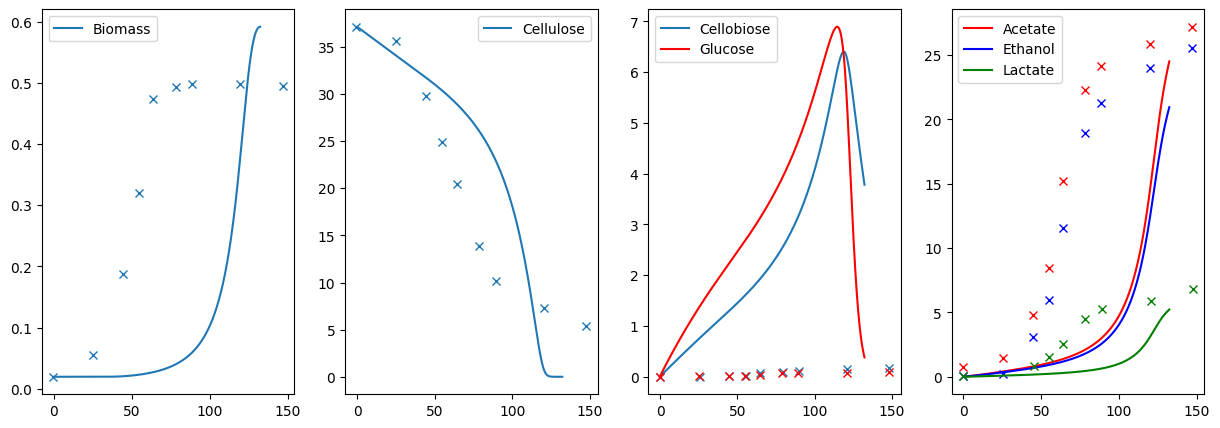

In [40]:
fig,ax = plt.subplots(1,4,figsize=(15,5))

ax[0].plot(sol.t,C_dict_results["Growth"],label="Biomass")

ax[0].plot(biomass_exp.x,biomass_exp["y g"],'x',color="tab:blue")
ax[0].legend()

ax[1].plot(sol.t,C_dict_results["EX_cellulose_e"],label="Cellulose")
ax[1].plot(cellulose_exp.x,cellulose_exp["y mmol"],'x',color="tab:blue")
ax[1].legend()

ax[2].plot(sol.t,C_dict_results["EX_cellb_e"],label="Cellobiose")
ax[2].plot(cellb_exp.x,cellb_exp[" y"],'x',color="tab:blue")

ax[2].plot(sol.t,C_dict_results["EX_glc__D_e"],color="r",label="Glucose")
ax[2].plot(glc_exp.x,glc_exp[" y"],'x',color="r")

ax[2].legend()


ax[3].plot(sol.t,C_dict_results["EX_ac_e"],color="r",label="Acetate")
ax[3].plot(acetate_exp.x,acetate_exp[" y"],'x',color="r")


ax[3].plot(sol.t,C_dict_results["EX_etoh_e"],color="b",label="Ethanol")
ax[3].plot(ethanol_exp.x,ethanol_exp[" y"],'x',color="b")

ax[3].plot(sol.t,C_dict_results["EX_lac__L_e"],color="g",label="Lactate")
ax[3].plot(lactate_exp.x,lactate_exp[" y"],'x',color="g")
ax[3].legend()

#### Testing out a combination closer to the best values

In [22]:
combination = [6.01,0.2,5.01,0.2,2.9,4.4,11,0,0]

CPU times: user 13.1 s, sys: 2.22 s, total: 15.3 s
Wall time: 41min 41s

In [74]:
pd.Series({"result.x":[ 5.51984901,  0.18524121,  5.42517869,  0.1902395 ,  2.66153537,
        4.02279575, 11.73930932,  0.11992288,  0.04280795],
"result.success":True,
"results.convergence":"CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH",
"result.fun":21.353895719513883
})

result.x               [5.51984901, 0.18524121, 5.42517869, 0.1902395...
result.success                                                      True
results.convergence      CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
result.fun                                                     21.353896
dtype: object

In [29]:
combination = result.x


model = read_model(media)
sol,penalty,penalty_dict = optimize_parameters_inner_problem_cellulose(combination=combination,model=model,media=media,rxns=rxns,y0=y0,objective_dir=objective_dir,glc_eq_dict=glc_eq_dict,alternative_solution=True,t_end=150)
    

In [30]:
penalty_dict

{'penalty_growth': 6.990038387647931,
 'penalty_cellulose': 4.357499622605967,
 'penalty_acetate': 1.1148768296961604,
 'penalty_ethanol': 8.83632170804648,
 'penalty_lac': 0.05621924015412904}

In [31]:
C_dict_results = dict(zip(rxns,sol.y))

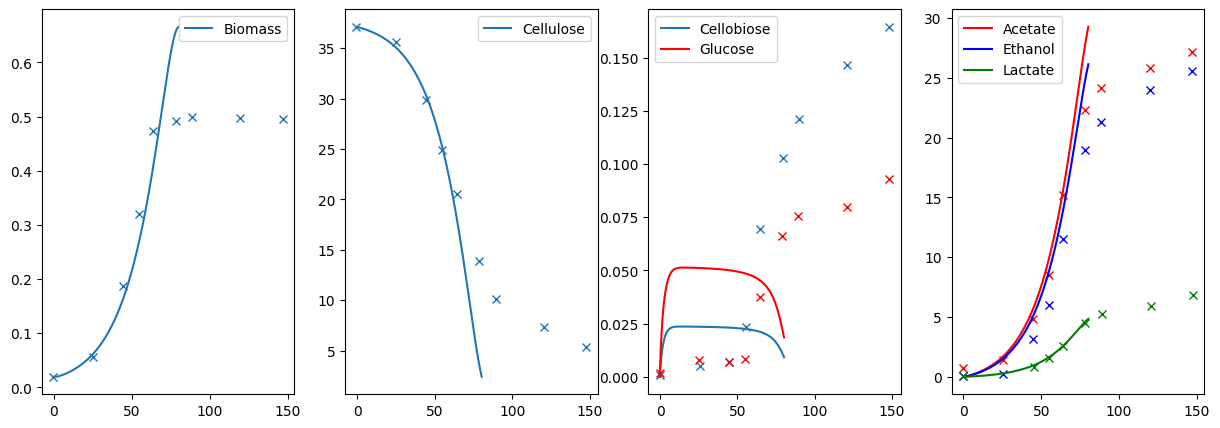

In [32]:
fig,ax = plt.subplots(1,4,figsize=(15,5))

ax[0].plot(sol.t,C_dict_results["Growth"],label="Biomass")

ax[0].plot(biomass_exp.x,biomass_exp["y g"],'x',color="tab:blue")
ax[0].legend()

ax[1].plot(sol.t,C_dict_results["EX_cellulose_e"],label="Cellulose")
ax[1].plot(cellulose_exp.x,cellulose_exp["y mmol"],'x',color="tab:blue")
ax[1].legend()

ax[2].plot(sol.t,C_dict_results["EX_cellb_e"],label="Cellobiose")
ax[2].plot(cellb_exp.x,cellb_exp[" y"],'x',color="tab:blue")

ax[2].plot(sol.t,C_dict_results["EX_glc__D_e"],color="r",label="Glucose")
ax[2].plot(glc_exp.x,glc_exp[" y"],'x',color="r")

ax[2].legend()


ax[3].plot(sol.t,C_dict_results["EX_ac_e"],color="r",label="Acetate")
ax[3].plot(acetate_exp.x,acetate_exp[" y"],'x',color="r")


ax[3].plot(sol.t,C_dict_results["EX_etoh_e"],color="b",label="Ethanol")
ax[3].plot(ethanol_exp.x,ethanol_exp[" y"],'x',color="b")

ax[3].plot(sol.t,C_dict_results["EX_lac__L_e"],color="g",label="Lactate")
ax[3].plot(lactate_exp.x,lactate_exp[" y"],'x',color="g")
ax[3].legend()

#### Another combination

In [64]:
combination = [ 3.51984901,  1.18524121,  3.42517869,  1.1902395 ,  4.66153537,
        10, 11.73930932,  0.2,  0.04280795]

In [65]:
model = read_model(media)
sol,penalty,penalty_dict = optimize_parameters_inner_problem_cellulose(combination=combination,model=model,media=media,rxns=rxns,y0=y0,objective_dir=objective_dir,glc_eq_dict=glc_eq_dict,alternative_solution=True,t_end=150)
    

[3.51984901, 1.18524121, 3.42517869, 1.1902395, 4.66153537, 10, 11.73930932, 0.2, 0.04280795]
1-r2: 263.7990873615984


In [66]:
penalty_dict

{'penalty_growth': 62.169497412241164,
 'penalty_cellulose': 128.48593222620303,
 'penalty_acetate': 29.307825793262936,
 'penalty_ethanol': 39.70942101407155,
 'penalty_lac': 4.126410915819728}

In [67]:
C_dict_results = dict(zip(rxns,sol.y))

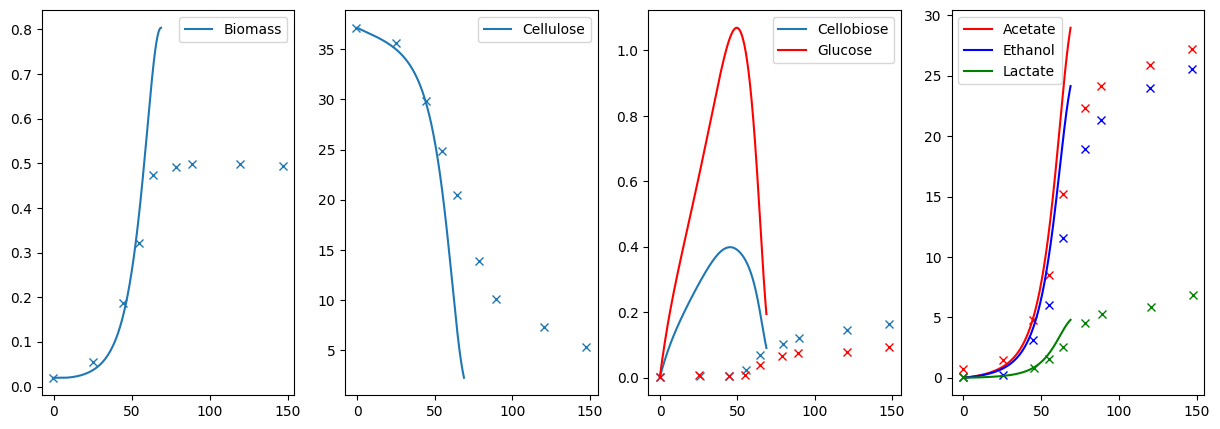

In [68]:
fig,ax = plt.subplots(1,4,figsize=(15,5))

ax[0].plot(sol.t,C_dict_results["Growth"],label="Biomass")

ax[0].plot(biomass_exp.x,biomass_exp["y g"],'x',color="tab:blue")
ax[0].legend()

ax[1].plot(sol.t,C_dict_results["EX_cellulose_e"],label="Cellulose")
ax[1].plot(cellulose_exp.x,cellulose_exp["y mmol"],'x',color="tab:blue")
ax[1].legend()

ax[2].plot(sol.t,C_dict_results["EX_cellb_e"],label="Cellobiose")
ax[2].plot(cellb_exp.x,cellb_exp[" y"],'x',color="tab:blue")

ax[2].plot(sol.t,C_dict_results["EX_glc__D_e"],color="r",label="Glucose")
ax[2].plot(glc_exp.x,glc_exp[" y"],'x',color="r")

ax[2].legend()


ax[3].plot(sol.t,C_dict_results["EX_ac_e"],color="r",label="Acetate")
ax[3].plot(acetate_exp.x,acetate_exp[" y"],'x',color="r")


ax[3].plot(sol.t,C_dict_results["EX_etoh_e"],color="b",label="Ethanol")
ax[3].plot(ethanol_exp.x,ethanol_exp[" y"],'x',color="b")

ax[3].plot(sol.t,C_dict_results["EX_lac__L_e"],color="g",label="Lactate")
ax[3].plot(lactate_exp.x,lactate_exp[" y"],'x',color="g")
ax[3].legend()